![Титульный лист](https://sun9-16.userapi.com/pZ8LejyT0ocpEHFdg4pP2CJPy3LUy28K4RCiag/VCjYuCppmU8.jpg "Титульный лист")


# Содержание

# 1.  Описание набора данных и решаемой задачи.

Само понятие верификации финансовых транзакций подразумевает наличие этих транзакций. Именно поэтому на сайте kaggle.com был выбран подходящий тематике курсовой работы набор данных "Fraud transactions detection", состоящий из реальных данных с указанным признаком «плохой» транзакции «bad_flag». Именно атрибут «bad_flag» является целевой переменной в дата-сете.
Категориальные признаки (названия товаров, и т.д.) не будут рассматриваться в процессе работы, ровным счётом как и ID-коды транзакций, которые не должны участвовать в обучении. Будет осуществляться лишь поиск подозрительных транзакций.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import seaborn as sns

import pandas as pd 
from sklearn.model_selection import train_test_split,  cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, make_scorer, recall_score
from sklearn.svm import SVC

import warnings
from time import time
from scipy.stats import randint as sp_randint
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats.kde import gaussian_kde
from numpy import linspace,hstack
from pylab import plot,show,hist

Приготовимся к описанию нашего дата-сета; для начала выведем несколько первых строк с целью убедиться, что набор данных считался и готов к работе.

In [2]:
DS = pd.read_csv("fraud.csv", delimiter=',')  

Выведем первые несколько строк таблицы с набором наших данных:

In [3]:
DS.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,307a838f523ff4963ff3d9436b04be90,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,1679091c5a880faf6fb5e6087eb1b2dc,...,6,0,0,0,5.0,NaN,NaN,20.0,False,0
1,779ad1fcf8fa5a1fb863e725ba02f3ea,2016-10-30,2015-12-21,NaN,NaN,NaN,NaN,2.0,region_1,1679091c5a880faf6fb5e6087eb1b2dc,...,0,5,0,0,5.0,NaN,NaN,19.0,False,0
2,665d9bb66b1dcb65e89f922ac00f1f45,2016-06-29,2015-06-30,NaN,NaN,NaN,NaN,1.0,region_6,aab3238922bcc25a6f606eb525ffdc56,...,4,0,0,0,6.0,NaN,NaN,21.0,False,0
3,0af212b8130a0285ca67dfeb57c64a68,2015-12-01,2015-08-03,NaN,NaN,NaN,NaN,0.0,region_5,b6d767d2f8ed5d21a44b0e5886680cb9,...,0,0,0,0,3.0,NaN,NaN,33.0,False,0
4,5f13b34f42f732620491c282ae56bc23,2016-10-01,2015-08-30,NaN,NaN,NaN,NaN,2.0,region_3,a5771bce93e200c36f7cd9dfd0e5deaa,...,6,0,0,0,5.0,NaN,NaN,34.0,False,0


Найдём процентное соотношение "плохих" транзакций, помеченных атрибутом "bad_flag", к нормально верифицированным платежам:

In [4]:
percent_bad = DS[DS['bad_flag'] == 1]
percent_bad_1 = np.round(len(percent_bad)/len(DS)*100,2)
print("Процент плохих транзакций в наборе данных составляет:", percent_bad_1,"%")

Процент плохих транзакций в наборе данных составляет: 10.03 %


Логично, что процент нормально верифицированных платежей в наборе данных составляет:

In [5]:
print(100 - percent_bad_1,"%")

89.97 %


Для наглядности построим круговую диаграмму, которая покажет данное соотношение:

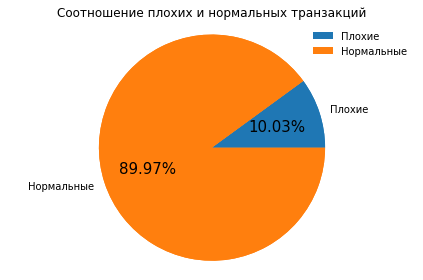

In [6]:
labels = ['Плохие', 'Нормальные']
value = [DS[DS['bad_flag'] == 1]['bad_flag'].count(),DS[DS['bad_flag'] == 0]['bad_flag'].count()]
value = pd.Series(value)
fig, ax = plt.subplots()
ax.pie(value, labels=labels)
value.plot(kind='pie', labels=['', ''],
                                   ax=ax, autopct='%.2f%%', fontsize=15)
ax.set_title(u'Соотношение плохих и нормальных транзакций')
ax.axis('equal')
ax.legend(labels=[u'Плохие', u'Нормальные'], framealpha = 0)
ax.set_ylabel('')
plt.tight_layout()

Количество точек данных (измерений) в наборе:

In [7]:
len(DS)

4156

Количество полей данных (атрибутов):

In [8]:
len(DS.columns)

22

Названия всех атрибутов в наборе данных:

In [9]:
DS.columns

Index(['loanKey', 'rep_loan_date', 'first_loan', 'dpd_5_cnt', 'dpd_15_cnt',
       'dpd_30_cnt', 'first_overdue_date', 'close_loans_cnt',
       'federal_district_nm', 'TraderKey', 'payment_type_0', 'payment_type_1',
       'payment_type_2', 'payment_type_3', 'payment_type_4', 'payment_type_5',
       'past_billings_cnt', 'score_1', 'score_2', 'age', 'gender', 'bad_flag'],
      dtype='object')

Количество отсутствующих значений для каждого поля:

In [10]:
len(DS) - DS.count()

loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt              3481
dpd_15_cnt             3481
dpd_30_cnt             3481
first_overdue_date     3481
close_loans_cnt          15
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt       248
score_1                 649
score_2                3917
age                       0
gender                    0
bad_flag                  0
dtype: int64

То же самое, но в процентном представлении:

In [11]:
(DS.isna().sum(axis=0)/len(DS)).sort_values()

loanKey                0.000000
age                    0.000000
payment_type_5         0.000000
payment_type_4         0.000000
payment_type_3         0.000000
payment_type_2         0.000000
payment_type_1         0.000000
gender                 0.000000
TraderKey              0.000000
payment_type_0         0.000000
first_loan             0.000000
rep_loan_date          0.000000
bad_flag               0.000000
federal_district_nm    0.002647
close_loans_cnt        0.003609
past_billings_cnt      0.059673
score_1                0.156160
first_overdue_date     0.837584
dpd_30_cnt             0.837584
dpd_15_cnt             0.837584
dpd_5_cnt              0.837584
score_2                0.942493
dtype: float64

Общая информация о дата-сете:

In [12]:
DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 22 columns):
loanKey                4156 non-null object
rep_loan_date          4156 non-null object
first_loan             4156 non-null object
dpd_5_cnt              675 non-null float64
dpd_15_cnt             675 non-null float64
dpd_30_cnt             675 non-null float64
first_overdue_date     675 non-null object
close_loans_cnt        4141 non-null float64
federal_district_nm    4145 non-null object
TraderKey              4156 non-null object
payment_type_0         4156 non-null int64
payment_type_1         4156 non-null int64
payment_type_2         4156 non-null int64
payment_type_3         4156 non-null int64
payment_type_4         4156 non-null int64
payment_type_5         4156 non-null int64
past_billings_cnt      3908 non-null float64
score_1                3507 non-null float64
score_2                239 non-null float64
age                    4156 non-null float64
gender          

Количество строк и столбцов в дата-сете соответственно:

In [13]:
DS.shape

(4156, 22)

Общая описательная статистика дата-сета:

In [14]:
DS.describe()

,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,bad_flag
count,675.000000,675.000000,675.000000,4141.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.0,3908.000000,3507.000000,239.000000,4156.000000,4156.000000
mean,1.444444,0.733333,0.280000,1.184255,0.018527,0.596246,3.754331,0.758422,0.019490,0.0,4.977738,578.911345,552.546610,34.564485,0.100337
std,0.900599,0.764572,0.502339,1.723692,0.330399,2.565179,3.809930,2.212722,0.245989,0.0,3.491078,48.989869,21.492840,10.833403,0.300485
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,384.220628,485.874267,18.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.000000,547.429791,535.545724,26.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,4.000000,588.531315,556.757944,32.000000,0.000000
75%,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.0,6.000000,612.323090,567.608057,41.000000,0.000000
max,7.000000,5.000000,3.000000,31.000000,15.000000,81.000000,33.000000,35.000000,7.000000,0.0,21.000000,691.528420,603.311653,74.000000,1.000000


Тип данных каждого поля, шкала каждого поля:

In [15]:
DS.dtypes

loanKey                 object
rep_loan_date           object
first_loan              object
dpd_5_cnt              float64
dpd_15_cnt             float64
dpd_30_cnt             float64
first_overdue_date      object
close_loans_cnt        float64
federal_district_nm     object
TraderKey               object
payment_type_0           int64
payment_type_1           int64
payment_type_2           int64
payment_type_3           int64
payment_type_4           int64
payment_type_5           int64
past_billings_cnt      float64
score_1                float64
score_2                float64
age                    float64
gender                    bool
bad_flag                 int64
dtype: object

Количество уникальных значений для каждого атрибута:

In [16]:
DS.nunique() 

loanKey                4156
rep_loan_date           582
first_loan              634
dpd_5_cnt                 8
dpd_15_cnt                6
dpd_30_cnt                4
first_overdue_date       78
close_loans_cnt          21
federal_district_nm       8
TraderKey                23
payment_type_0            9
payment_type_1           28
payment_type_2           26
payment_type_3           24
payment_type_4            7
payment_type_5            1
past_billings_cnt        21
score_1                1274
score_2                  47
age                      51
gender                    2
bad_flag                  2
dtype: int64

Удалим те атрибуты, в которых более 5% отсутствующих значений. Это поля: past_billings_cnt, score_1, first_overdue_date, dpd_30_cnt, dpd_15_cnt, dpd_5_cnt, score_2.           
       
                

In [17]:
del DS['past_billings_cnt']
del DS['score_1']
del DS['first_overdue_date']
del DS['dpd_30_cnt']
del DS['dpd_15_cnt']
del DS['dpd_5_cnt']
del DS['score_2']
DS

,loanKey,rep_loan_date,first_loan,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,age,gender,bad_flag
0,307a838f523ff4963ff3d9436b04be90,2016-03-26,2015-09-28,0.0,region_6,1679091c5a880faf6fb5e6087eb1b2dc,0,0,6,0,0,0,20.0,False,0
1,779ad1fcf8fa5a1fb863e725ba02f3ea,2016-10-30,2015-12-21,2.0,region_1,1679091c5a880faf6fb5e6087eb1b2dc,0,0,0,5,0,0,19.0,False,0
2,665d9bb66b1dcb65e89f922ac00f1f45,2016-06-29,2015-06-30,1.0,region_6,aab3238922bcc25a6f606eb525ffdc56,0,0,4,0,0,0,21.0,False,0
3,0af212b8130a0285ca67dfeb57c64a68,2015-12-01,2015-08-03,0.0,region_5,b6d767d2f8ed5d21a44b0e5886680cb9,0,3,0,0,0,0,33.0,False,0
4,5f13b34f42f732620491c282ae56bc23,2016-10-01,2015-08-30,2.0,region_3,a5771bce93e200c36f7cd9dfd0e5deaa,0,0,6,0,0,0,34.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151,cf43bb28e8c5ecf07d8bb32a243d9e39,2016-06-11,2016-05-17,0.0,region_5,8f14e45fceea167a5a36dedd4bea2543,0,0,1,0,0,0,26.0,False,0
4152,4a31ec1c6d5e4809c4677e873f92b243,2016-08-06,2016-03-11,1.0,region_2,c20ad4d76fe97759aa27a0c99bff6710,0,0,4,0,0,0,38.0,False,1
4153,4140d1e8424e12c890d439e5472e2deb,2016-09-05,2016-04-30,1.0,region_2,c20ad4d76fe97759aa27a0c99bff6710,0,0,4,0,0,0,21.0,False,0
4154,8b03ab03763644b74c9c01030209206b,2016-10-14,2016-05-20,0.0,region_6,8f14e45fceea167a5a36dedd4bea2543,0,0,4,0,0,0,35.0,False,0


С таким же успехом можно удалить другим способом ещё 4 категориальных атрибута, которые не влияют на распознавание "подозрительности" транзакции: это их ID-коды, регион, где совершался платёж, а также "битый" столбец с полом, где все значения указаны как "False".

In [18]:
DS = DS.drop(['first_loan','loanKey', 'rep_loan_date', 'TraderKey','federal_district_nm','gender'],axis = 1)
DS

,close_loans_cnt,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,age,bad_flag
0,0.0,0,0,6,0,0,0,20.0,0
1,2.0,0,0,0,5,0,0,19.0,0
2,1.0,0,0,4,0,0,0,21.0,0
3,0.0,0,3,0,0,0,0,33.0,0
4,2.0,0,0,6,0,0,0,34.0,0
...,...,...,...,...,...,...,...,...,...
4151,0.0,0,0,1,0,0,0,26.0,0
4152,1.0,0,0,4,0,0,0,38.0,1
4153,1.0,0,0,4,0,0,0,21.0,0
4154,0.0,0,0,4,0,0,0,35.0,0


In [19]:
DS.shape

(4156, 9)

# 2. Разделение набора данных на обучающую и тестовую выборки. 

Машинное обучение по своему определнию представляет собой обучение выделению некоторых свойств выборки данных и их применение на новых данных. Поэтому, исходя из общепринятой практики оценки алгоритма в машинном обучении, на втором этапе работы над курсовой необходимо вручную разбить данные на два отдельных набора. Первый — обучающая выборка, на которой будут изучаться свойства данных, а второй — тестовая выборка, на которой выделенные свойства будут тестироваться.

В процессе разделения будет использован случайный метод, который к тому же работает по умолчанию. Прочие методы было решено не использовать в силу специфики задачи. 

Разделим набор данных на обучающую и тестовую выборки с помощью метода train_test_split, но сначала превратим дата-сет во фрейм данных и определим имена его столбцов:

In [20]:
columns = "payment_type_0 payment_type_1 payment_type_2 payment_type_3 payment_type_4 payment_type_5 age".split() # объявляем имена столбцов для работы над выборками
x = pd.DataFrame(DS, columns = columns)
y = DS.bad_flag # определяем целевую перменную как "y"

Теперь мы можем использовать функцию train_test_split для разделения набора данных на обучающую и тестовую выборки.

Пусть параметр test_size = 0,2 внутри функции указывает процент данных, которые должны быть сохранены для тестирования. 
Обычно это соотношения около 80/20 или 70/30. Разбиение данных на две этих выборки выглядит следующим образом:

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2) 

In [22]:
x_train.shape

(3324, 7)

In [23]:
y_train.shape

(3324,)

In [24]:
x_test.shape

(832, 7)

In [25]:
y_test.shape

(832,)

In [26]:
DS.shape

(4156, 9)

# 3. Обучение нескольких моделей для решения выбранной задачи.
## 3.1. Алгоритм наивного байесовского классификатора.

Первой моделью решения задачи выступит алгоритм наивного Байесовского классификатора. Он, к тому же, считается одним из самых простых алгоритмов классификации. При этом ему удаётся работать не хуже, а то и лучше некоторых более сложных алгоритмов.

Здесь мы собираемся использовать модель GaussianNB, которая доступна в библиотеке Sckit-learn. Создание нашей наивной байесовской модели будет возможным с использованием метода GaussianNB():

In [27]:
NBC = GaussianNB()
NBC_2 = NBC.fit(x, y)

Сделаем прогнозы на основе разделения данных на целевую переменную и прочие:

In [28]:
expected_test = y_test
predicted_test = NBC.predict(x_test)

In [29]:
expected_train = y_train
predicted_train = NBC.predict(x_train)

Что касается получения точности и статистики, то теперь имеет смысл создать отчёт о классификации, который будет содержать различные статистические данные, необходимые для оценки модели. И перед переходом к анализу метрик необходимо будет ввести важную концепцию для описания этих метрик в терминах ошибок классификации, а именно — confusion matrix (матрицу ошибок), которая имеет следующий вид:

![вид матрицы ошибок](https://sun9-24.userapi.com/BUpDzkAT__m1qptu5UFb6C60IAGpDND8ACsrfg/phRujTtXcwE.jpg "вид матрицы ошибок")

Здесь ŷ — это ответ алгоритма на объекте, а y — истинная метка класса на этом объекте.
Таким образом, ошибки классификации бывают двух видов: False Negative (FN) и False Positive (FP).

#### Матрица ошибок для тестовой выборки:

In [30]:
print(metrics.confusion_matrix(expected_test, predicted_test))

[[746  11]
 [ 74   1]]


#### Матрица ошибок для обучающей выборки:

In [31]:
print(metrics.confusion_matrix(expected_train, predicted_train))

[[2956   26]
 [ 339    3]]


Интуитивно понятной, очевидной (и почти неиспользуемой) метрикой является accuracy — доля правильных ответов алгоритма.
Для оценки качества работы алгоритма также введём метрики precision (точность) и recall (полнота). Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

#### Классификационный отчет для тестовой выборки:

In [130]:
print(metrics.classification_report(expected_test, predicted_test))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       757
           1       0.17      0.03      0.05        75

    accuracy                           0.90       832
   macro avg       0.54      0.51      0.50       832
weighted avg       0.84      0.90      0.87       832



#### Классификационный отчет для обучающей выборки:

In [131]:
print(metrics.classification_report(expected_train, predicted_train))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2982
           1       0.07      0.01      0.01       342

    accuracy                           0.89      3324
   macro avg       0.48      0.50      0.48      3324
weighted avg       0.81      0.89      0.85      3324



####  Оценка точности на тестовой выборке:

In [132]:
NBC_score_test = display(NBC.score(x_test, y_test))

0.9002403846153846

#### Оценка точности на обучающей выборке:

In [133]:
NBC_score_train =display(NBC.score(x_train, y_train))

0.8895908543922985

## 3.2. Алгоритм итеративного дихотомизатора (ID3).

Алгоритм итеративного дихотомизатора является одним из самых популярных алгоритмов, подразумевающих собой построение дерева решений. В данных методах сначала строится модель решений, которые принимаются на основе фактических значений атрибутов в данных. Решения распадаются на древовидные структуры до тех пор, пока не будет принято прогнозирующее решение для данной записи. Деревья решений обучаются на данных для задач классификации и регрессии. Деревья решений часто бывают быстрыми и точными и пользуются большой популярностью в машинном обучении.

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
ID3 = DecisionTreeClassifier()
ID3_fit = ID3.fit(x_train, y_train)

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0] # true_negative
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1] # false_positive
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0] # false_negative
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1] # true_positive

scoring = {
    'tp' : make_scorer(tp), 
    'tn' : make_scorer(tn), 
    'fp' : make_scorer(fp), 
    'fn' : make_scorer(fn), 
    'accuracy' : make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'f1_score' : make_scorer(f1_score),
    'recall'   : make_scorer(recall_score)
}

sc = cross_validate(ID3_fit, x_train, y_train, cv = 5, scoring = scoring)

In [31]:
expected_test_1 = y_test
predicted_test_1 = ID3_fit.predict(x_test)

In [32]:
expected_train_1 = y_train
predicted_train_1 = ID3_fit.predict(x_train)

#### Матрица ошибок для тестовой выборки:

In [35]:
print(metrics.confusion_matrix(expected_test_1, predicted_test_1))

[[718  30]
 [ 79   5]]


#### Матрица ошибок для обучающей выборки:

In [36]:
print(metrics.confusion_matrix(expected_train_1, predicted_train_1))

[[2982    9]
 [ 233  100]]


#### Классификационный отчет для тестовой выборки:

In [139]:
print(metrics.classification_report(expected_test_1, predicted_test_1))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       739
           1       0.23      0.08      0.11        93

    accuracy                           0.87       832
   macro avg       0.56      0.52      0.52       832
weighted avg       0.82      0.87      0.84       832



#### Классификационный отчет для обучающей выборки:

In [140]:
print(metrics.classification_report(expected_train_1, predicted_train_1))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3000
           1       0.88      0.30      0.45       324

    accuracy                           0.93      3324
   macro avg       0.91      0.65      0.71      3324
weighted avg       0.93      0.93      0.91      3324



####  Оценка точности на тестовой выборке:

In [141]:
ID3_score_test = display(ID3.score(x_test, y_test))

0.8689903846153846

####  Оценка точности на обучающей выборке:

In [142]:
ID3_score_train = display(ID3.score(x_train, y_train))

0.9280986762936222

# 4. Выбор наиболее перспективной модели для решения поставленной задачи. 

Наиболее перспективной моделью для решения поставленной задачи по машинному обучению выявления подзрительных финансовых транзакций был выбран алгоритм наивного байесовского классификатора, поскольку по результатам, описанным в классификационных отчётах по тестовым и обучающим выборкам, тот показал более уверенные проценты в оценке точности, нежели алгоритм ID3. Точность между обучающей и тестовой выборкой в нём разнится примерно на 1%, в то время как точность по итеративному дихотомизатору отличается почти на 6%.

## 4.1. Поиск оптимальных гиперпараметров.

В машинном обучении гиперпараметрами называют параметры алгоритмов, значения которых устанавливаются перед запуском процесса обучения. В этом смысле они и отличаются от обычных параметров, вычисляемых в процессе обучения. Гиперпараметры используются для управления процессом обучения.

Один из способов настройки гиперпараметров состоит в том, чтобы заставить компьютер попробовать все возможные комбинации значений параметров. Для этого используем модуль GridSearchCV из библиотеки Scikit Learn. Попытаемся найти наилучшую комбинацию гиперпараметров (C, Gamma и Kernel) для построения классификатора для нашего набора данных.

Первым делом найдём такие гиперпараметры, как kernel, gamma и C.

#### GridSearch:

In [45]:
warnings.filterwarnings("ignore")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2) 
tuned_parameters = [{'kernel': ['rbf','sigmoid', 'linear'], 'gamma': [1e-3, 1e-4, 1e-2], 'C': [1, 10, 100, 1000]}]
scores = ['precision']

clf = GridSearchCV(SVC(), tuned_parameters, cv = 5, scoring = '%s_macro' % scores[0])
clf.fit(x_test, y_test)

print("Оптимальные гиперпараметры:")
print(clf.best_params_)

print("Grid-метрики:")
means = clf.cv_results_['mean_test_score']
for mean,params in zip(means, clf.cv_results_['params']):
    print("%0.3f for %r" % (mean, params))

Оптимальные гиперпараметры:
{'C': 100, 'gamma': 0.0001, 'kernel': 'sigmoid'}
Grid-метрики:
0.447 for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.454 for {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.447 for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
0.447 for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.447 for {'C': 1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.447 for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.447 for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.447 for {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.447 for {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
0.447 for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.451 for {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.447 for {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
0.447 for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.447 for {'C': 10, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.447 for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
0.446 for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.447 for {'C': 10, 'gamma': 0.01

Приведенный выше код перебирает силу и пробует каждую возможную комбинацию этих трех гиперпараметров, а затем выводит наилучшую комбинацию.

Также можем опробовать случайный поиск. Как следует из названия, он будет пытаться случайным образом выбрать заранее определенное количество комбинаций гиперпараметров, которые дадут некоторое представление о том, какие из них будут оптимальными.

Теперь поищем гиперпараметры max_depth, min_samples_split, criterion и bootstrap.

#### Случайный поиск:

In [46]:
rfc = RandomForestClassifier(n_estimators = 20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

hp = {"max_depth": [4, 3, 2],
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"],
              "bootstrap": [True, False]
              }

n_iter_search = 10
random_search = RandomizedSearchCV(rfc, param_distributions = hp, n_iter = n_iter_search, cv = 5, iid = False)

start = time()
random_search.fit(x_test, y_test) 
print("RandomizedSearchCV потребовалось %.2f секунд для вывода %d"
      " параметров." % ((time() - start), n_iter_search))
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

RandomizedSearchCV потребовалось 1.31 секунд для вывода 10 параметров.
0.892 (+/-0.001) for {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3}
0.893 (+/-0.005) for {'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
0.892 (+/-0.001) for {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 5}
0.889 (+/-0.009) for {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 3}
0.891 (+/-0.004) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 5}
0.892 (+/-0.001) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4}
0.892 (+/-0.001) for {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 7}
0.892 (+/-0.001) for {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 4}
0.893 (+/-0.005) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split':

# 5. Сравнение результатов.

Ещё раз убедимся в том, что оценки точности по алгоритму ID3 различаются на довольно существенные ~6%, чего не скажешь о разнице оценок по алгоритму наивного байесовского классификатора.

In [144]:
print ('Разница в оценках точности выборок по алгоритму NBC:',(0.9002403846153846 - 0.8895908543922985)*100,'%')
print ('Разница в оценках точности выборок по алгоритму ID3:',(0.9280986762936222 - 0.8689903846153846)*100,'%')

Разница в оценках точности выборок по алгоритму NBC: 1.0649530223086123 %
Разница в оценках точности выборок по алгоритму ID3: 5.910829167823762 %


Что касается сравнения работы двух методов поиска гиперпараметров, то здесь можно выделить положительные и отрицательные стороны для них обоих.

<b> Метод GridSearch: </b>

ПЛЮСЫ: Этот метод получит требуемые оптимальные гиперпараметры.

МИНУСЫ: Является самой затратной по времени на обработку операцией, что значительно замедляет процесс, например, экспресс-проверки работы алгоритма, занимая несколько минут и не давая запущенным после себя операциям выводить свои результаты на экран. 


<b> Метод случайного поиска: </b>

ПЛЮСЫ: Гораздо быстрее, чем метод Grid Search.

МИНУСЫ: Может не возвращать оптимальную комбинацию гиперпараметров, которая вернула бы лучшую точность. Он также не учитывает прошлые оценки и продолжает итерации вне зависимости от результатов.

# 6. Представление результатов моделирования с использованием визуализации.

### 1. Корреляционная матрица:

In [39]:
def plotCorrelationMatrix(DS, graphWidth):
    filename = 'fraud.csv'
    DS = DS.dropna('columns') 
    DS = DS[[col for col in DS if DS[col].nunique() > 1]] 
    if DS.shape[1] < 2:
        print(f'Не удалось вывести график: количество не-NaN или столбцов-констатант ({DS.shape[1]}) менее 2')
        return
    corr = DS.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Корреляционная матрица для дата-сета {filename}', fontsize=15)
    plt.show()

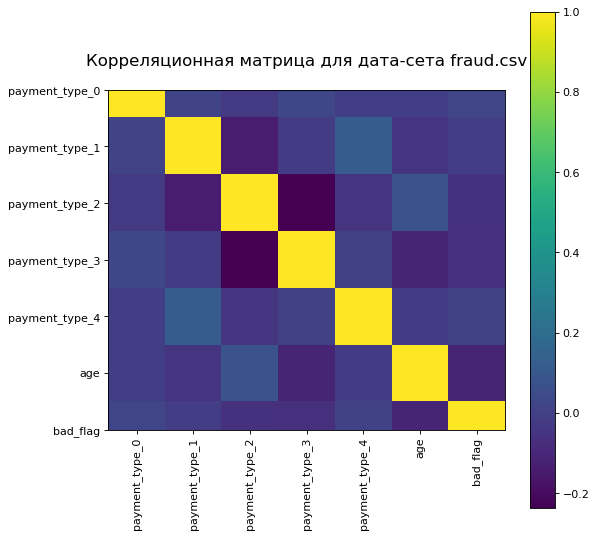

In [40]:
plotCorrelationMatrix(DS, 8)

### 2. Точечные графики плотности:

In [37]:
def plotScatterMatrix(DS, plotSize, textSize):
    DS = DS.select_dtypes(include =[np.number]) 
    DS = DS.dropna('columns')
    DS = DS[[col for col in DS if DS[col].nunique() > 1]] 
    columnNames = list(DS)
    if len(columnNames) > 10: 
        columnNames = columnNames[:10]
    DS = DS[columnNames]
    ax = pd.plotting.scatter_matrix(DS, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = DS.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Коэф. корр. = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Точечные графики плотности')
    plt.show()

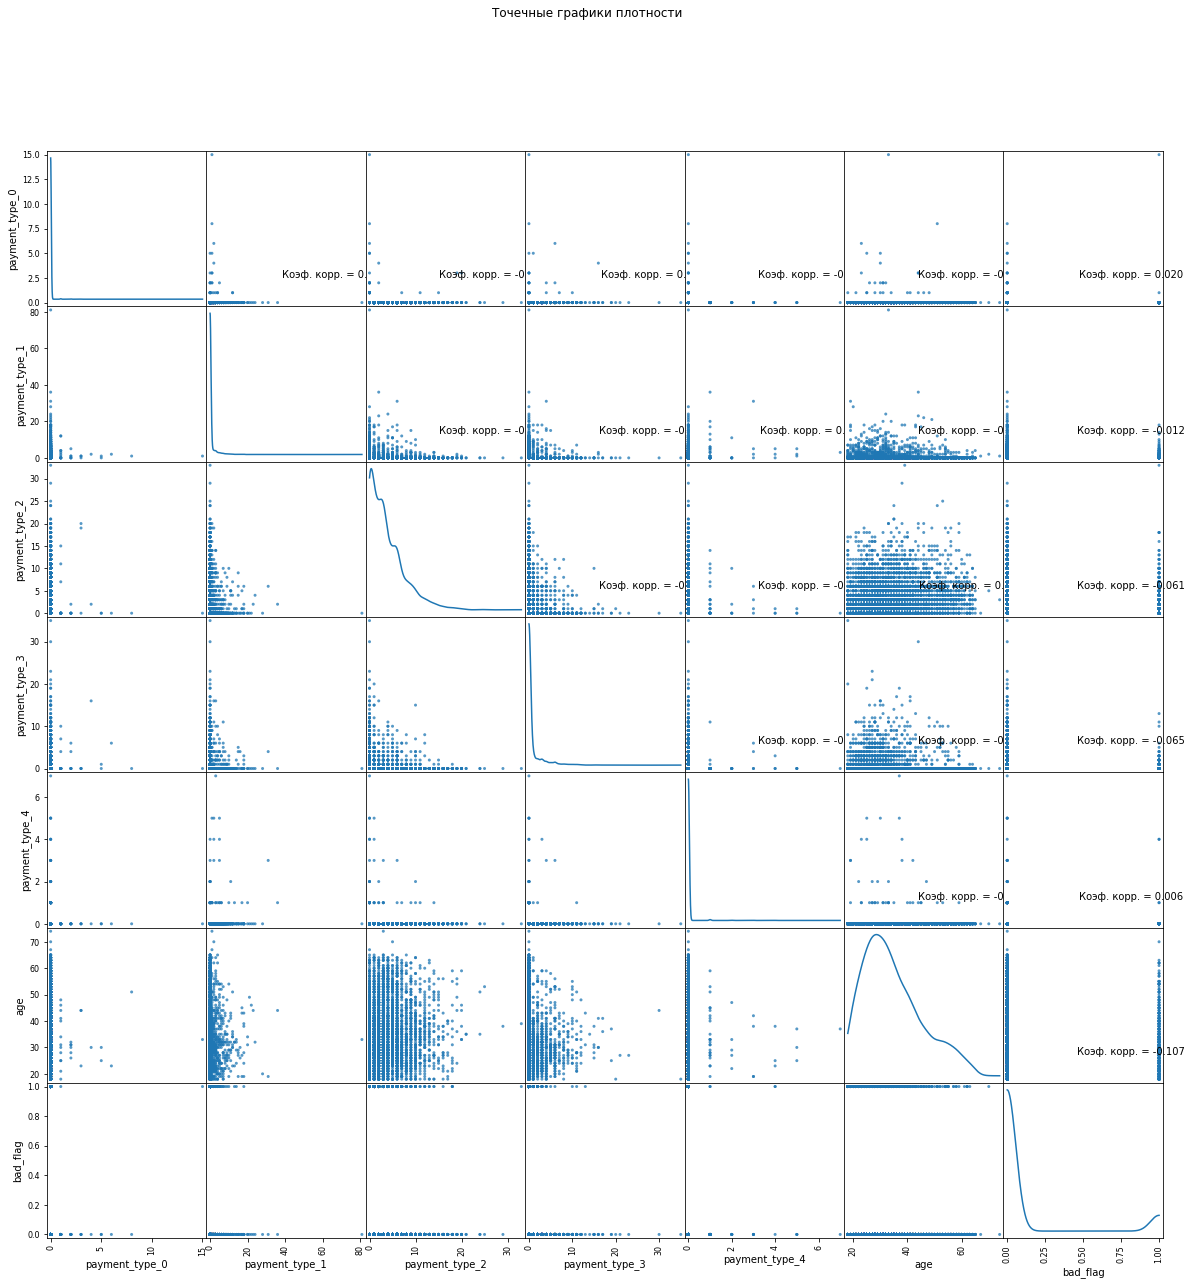

In [38]:
plotScatterMatrix(DS, 20, 10)

### 3. Box-plot:

На приведённой ниже диаграмме видно, что основной возраст людей в дата-сете сконцентрирован в интервале с 26 по 42.

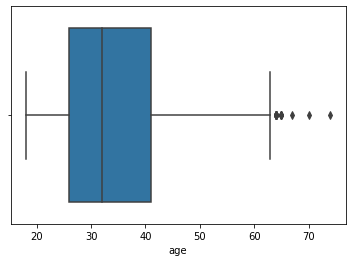

In [51]:
sns.boxplot(x = 'age', data = DS)

Распределение обучающей выборки (х):

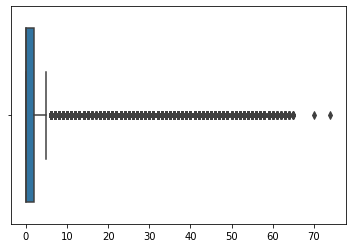

In [52]:
sns.boxplot(x = x_train, data = DS)

Распределение тестовой выборки (х):

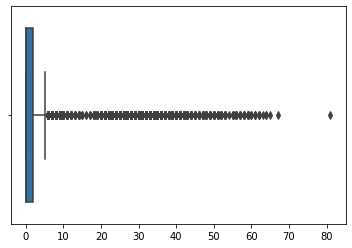

In [53]:
sns.boxplot(x = x_test, data = DS)

Судя по данной ящичковой диаграмме, становится понятно, что чаще всего "подозрительные" транзакции исходят от клиентов в возрасте от 23 до 28 лет, а самая законопослушная и неподозрительная прослойка населения (в рамках данного дата-сета) начинается с 38 лет.

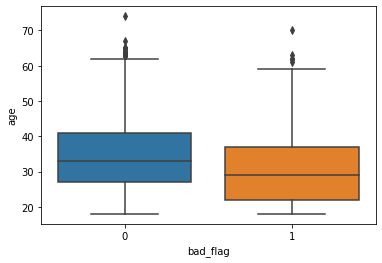

In [67]:
sns.boxplot(x='bad_flag', y = 'age', data=DS)

Та же диаграмма, но в альтернативном виде:

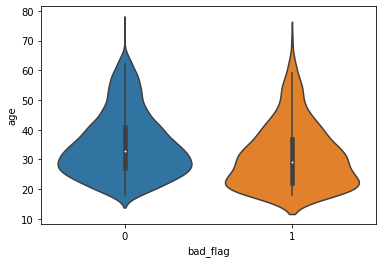

In [48]:
sns.violinplot(x = 'bad_flag', y = 'age', data=DS, split=True);

### 4. Гистограммы:

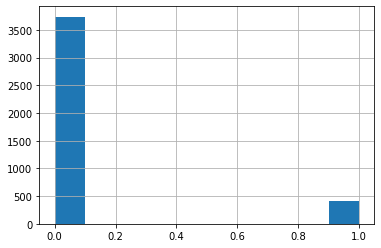

In [55]:
DS['bad_flag'].hist()

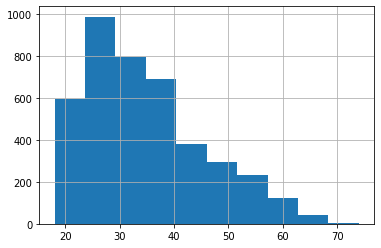

In [56]:
DS['age'].hist()

# 7. Заключение.

Подводя итоги, стоит сказать, что машинное обучение в задачах верификации финансовых транзакций – довольно сложный процесс, требующий не только навыков программирования, но и профессионального подхода к сфере самих финансовых транзакций. Необходимо понимать, на какие атрибуты нужно в первую очередь обратить внимание, чтобы суметь впоследствии грамотно и чётко спрогнозировать тот или иной признак.  В ходе работы был задействован дата-сет с реальными данными по теме, произведена его подробная опись и сопутствующий анализ; осуществлено биение данных на обучающую и тестовую выборки с использованием множества вспомогательных модулей из библиотеки SkLearn, которая во многом облегчила процесс машинного обучения и в целом была очень полезным инструментом в ходе работы над курсовой. В рамках машинного обучения и поиска гиперпараметров были задействованы 4 алгоритма: наивный байесовский классификатор, ID3, а также опорные вектора и случайный лес.  Поиск гиперпараметров осуществлялся при помощи таких методов, как «GridSearch» и «случайный поиск». Для каждой из выборок были составлены матрицы ошибок и классификационные отчёты, содержащие в себе основополагающие метрики, оценивающие качество проводимого обучения. В конечном итоге было представлено сравнение результатов оценок работы алгоритмов, а также различные графики и диаграммы, позволяющие наглядно оценить итоги проведенного обучения. Что касается перспектив решения проблемы выявления «подозрительных транзакций», то я думаю, что в таких случаях необходима целая команда программистов и финансовых аналитиков, способная к совместной работе над усовершенствованием уже существующих систем и поддержанием их качественного и бесперебойного функционирования.

# Список литературы и использумых источников: